In [1]:
import numpy as np
import pylab as plt
import pandas as pd
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import auc, precision_score, recall_score, average_precision_score
from scipy.stats import binned_statistic_2d

my_path = '/sdf/group/rubin/repo/main/u/dtaranu/DM-50135/w_2025_43/matched_cdfs/20251104T173543Z/matched_cdfs_mast_euclid_q1_object/5063/'

In [2]:
zeropoint = 31.4 # AB zero-point
def flux2mag(flux):
    return -2.5*np.log10(flux) + zeropoint


## Load data

In [3]:
# this a merged file of the Euclid Q1 and CDFS field
df_all = pd.read_parquet(my_path+'matched_cdfs_mast_euclid_q1_object_5063_lsst_cells_v1_u_dtaranu_DM-50135_w_2025_43_matched_cdfs_20251104T173543Z.parq')
#print(df.head())             

In [4]:
# cell for exploring the data
#print(df.columns.tolist())
#print(df['coord_best_ra'])
#print(df['coord_best_dec'])
matches = [s for s in df_all.columns.tolist() if 'Ext' in s]
print(matches)
i_flux_ratio = df_all['i_psfFlux'] / df_all['i_sersicFlux']
i_flux_ratio_err = np.sqrt((df_all['i_psfFluxErr']/df_all['i_sersicFlux'])**2 +
                           ((df_all['i_psfFlux']/df_all['i_sersicFlux']**2)*df_all['i_sersicFluxErr'])**2)
quality_mask = (df_all['euclid_det_quality_flag'] < 0.5) & (df_all['i_psfFlux']/df_all['i_psfFluxErr'] > 10) & (i_flux_ratio < 10) & (i_flux_ratio_err < 1)
df = df_all[quality_mask]
print(len(df))

['refExtendedness']
165202


## Create some LSST classifiers 

In [5]:
descoeff = 2.5
i_flux_ratio = df['i_psfFlux'] / df['i_sersicFlux']
i_flux_ratio_err = np.sqrt((df['i_psfFluxErr']/df['i_sersicFlux'])**2 +
                           ((df['i_psfFlux']/df['i_sersicFlux']**2)*df['i_sersicFluxErr'])**2)
df['deslike_class_sersic'] = (1 - i_flux_ratio) + descoeff*i_flux_ratio_err
i_flux_ratio = df['i_psfFlux'] / df['i_exponentialFlux']
i_flux_ratio_err = np.sqrt((df['i_psfFluxErr']/df['i_exponentialFlux'])**2 +
                           ((df['i_psfFlux']/df['i_exponentialFlux']**2)*df['i_exponentialFluxErr'])**2)
df['deslike_class_expon'] = (1 - i_flux_ratio) + descoeff*i_flux_ratio_err

df['extendedness_cont'] = flux2mag(df["i_psfFlux"]) - flux2mag(df["i_sersicFlux"])

/tmp/ipykernel_4802/2251380349.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['deslike_class_sersic'] = (1 - i_flux_ratio) + descoeff*i_flux_ratio_err
/tmp/ipykernel_4802/2251380349.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['deslike_class_expon'] = (1 - i_flux_ratio) + descoeff*i_flux_ratio_err
/tmp/ipykernel_4802/2251380349.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

## Plot ROC curve 

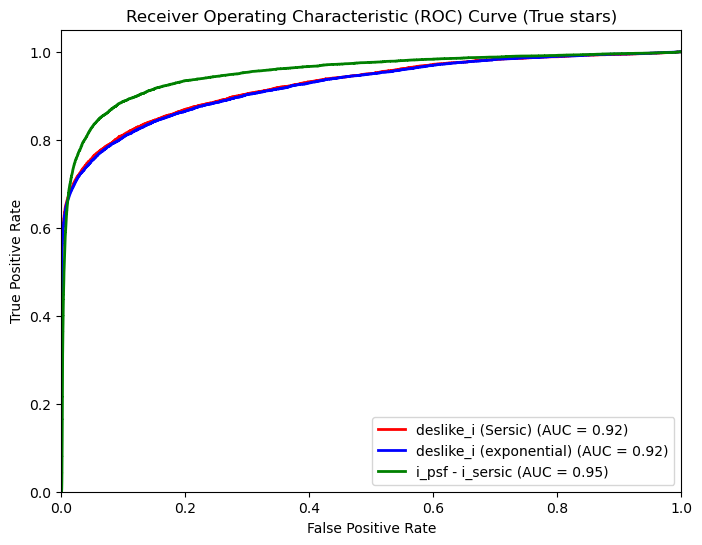

In [6]:
# define the truth labels (star is true in this case)
euclid_point_like_truth = (df['euclid_point_like_prob'] > 0.5).astype(int) 

classifiers = [
    {"name":'deslike_i (Sersic)','predicted':1-df['deslike_class_sersic'],'color':'red','linestyle':'solid'},
    {"name":'deslike_i (exponential)','predicted':1-df['deslike_class_expon'],'color':'blue','linestyle':'solid'},
    {"name":'i_psf - i_sersic','predicted':1-df['extendedness_cont'],'color':'green','linestyle':'solid'},
    #{"name":'refExtendedness','predicted':1-df['refExtendedness'],'color':'black','linestyle':'dashed'},
]
thresholds = [None] * len(classifiers)

plt.figure(figsize=(8,6))
for i in range(len(classifiers)):
    lsst_predicted = classifiers[i]['predicted']
    #drop NaNs and infs
    mask = (np.all([~np.isnan(a) for a in [lsst_predicted,euclid_point_like_truth]], axis=0)) & (~np.isinf(lsst_predicted))
    lsst_predicted_clean = lsst_predicted[mask]
    arr_isinf = np.isinf(lsst_predicted_clean)
    fpr, tpr, thresholds[i] = roc_curve(euclid_point_like_truth[mask], lsst_predicted_clean)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=classifiers[i]['color'], ls=classifiers[i]['linestyle'], 
             lw=2, label=f'{classifiers[i]['name']} (AUC = {roc_auc:.2f})')

#plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # random chance line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (True stars)')
plt.legend(loc="lower right")
plt.show()


## Plot completeness-purity plot

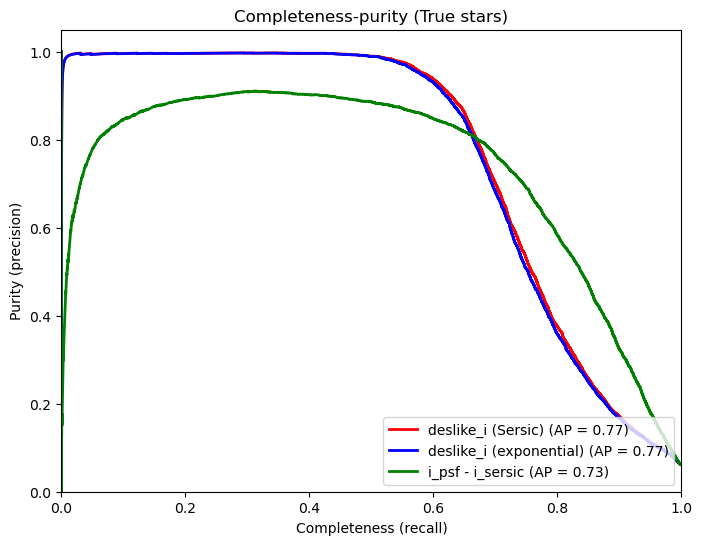

In [7]:
plt.figure(figsize=(8,6))
for i in range(len(classifiers)):
    lsst_predicted = classifiers[i]['predicted']
    #drop NaNs and infs
    mask = (np.all([~np.isnan(a) for a in [lsst_predicted,euclid_point_like_truth]], axis=0)) & (~np.isinf(lsst_predicted))
    lsst_predicted_clean = lsst_predicted[mask]
    arr_isinf = np.isinf(lsst_predicted_clean)
    precision, recall, thresholds[i] = precision_recall_curve(euclid_point_like_truth[mask], lsst_predicted_clean)
    ap = average_precision_score(euclid_point_like_truth[mask], lsst_predicted_clean)
    plt.plot(recall, precision, color=classifiers[i]['color'], ls=classifiers[i]['linestyle'], 
             lw=2, label=f'{classifiers[i]['name']} (AP = {ap:.2f})')

#plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # random chance line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Completeness (recall)')
plt.ylabel('Purity (precision)')
plt.title('Completeness-purity (True stars)')
plt.legend(loc="lower right")
plt.show()


## Plot classifiers loci

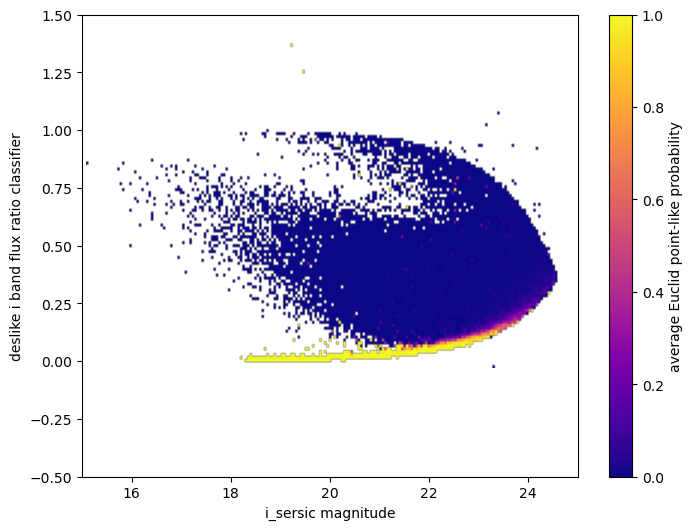

In [8]:
lsst_predicted = classifiers[0]['predicted']
#drop NaNs and infs
mask = (np.all([~np.isnan(a) for a in [lsst_predicted,euclid_point_like_truth]], axis=0)) & (~np.isinf(lsst_predicted))
x=flux2mag(df["i_sersicFlux"][mask])
y=df['deslike_class_sersic'][mask]
z=euclid_point_like_truth[mask]
#plt.hexbin(x,y, gridsize=200, cmap='plasma', bins='log')
stat, x_edges, y_edges, binnumber = binned_statistic_2d(
    x, y, z, statistic='mean', bins=200
)
plt.figure(figsize=(8,6))
#plt.hist2d(x, y, bins=300, cmap='plasma', norm='log')
plt.imshow(
    stat.T, origin='lower',
    extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
    aspect='auto', cmap='plasma'
)
plt.colorbar(label='average Euclid point-like probability')
plt.xlabel('i_sersic magnitude')
plt.ylabel('deslike i band flux ratio classifier')
#plt.scatter(x,y,marker='.')
plt.xlim(15,25)
plt.ylim(-0.5,1.5)
plt.show()

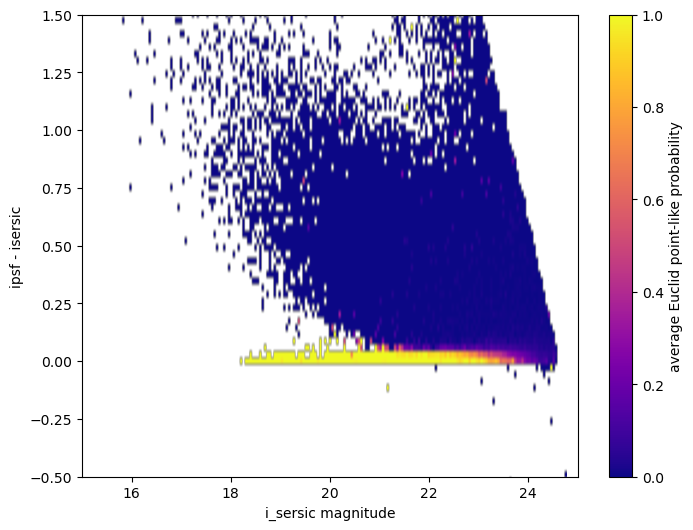

In [9]:
lsst_predicted = classifiers[2]['predicted']
#drop NaNs and infs
mask = (np.all([~np.isnan(a) for a in [lsst_predicted,euclid_point_like_truth]], axis=0)) & (~np.isinf(lsst_predicted))
x=flux2mag(df["i_sersicFlux"][mask])
y=df['extendedness_cont'][mask]
z=euclid_point_like_truth[mask]
#plt.hexbin(x,y, gridsize=200, cmap='plasma', bins='log')
stat, x_edges, y_edges, binnumber = binned_statistic_2d(
    x, y, z, statistic='mean', bins=200
)
plt.figure(figsize=(8,6))
#plt.hist2d(x, y, bins=300, cmap='plasma', norm='log')
plt.imshow(
    stat.T, origin='lower',
    extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
    aspect='auto', cmap='plasma'
)
plt.colorbar(label='average Euclid point-like probability')
plt.xlabel('i_sersic magnitude')
plt.ylabel('ipsf - isersic')
#plt.scatter(x,y,marker='.')
plt.xlim(15,25)
plt.ylim(-0.5,1.5)
plt.show()